### Import The Libraries

In [8]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow import keras
from skimage.transform import radon , iradon
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
np.random.seed(19743)

### Load the Data

In [9]:
from scipy.io import loadmat
scan = loadmat('Scans.mat')['ctscan']
mask = loadmat('Masks.mat')['infmsk']

### Split the Data Into Train-Val-Test

In [10]:
indices = np.arange(scan.shape[2])
np.random.shuffle(indices)
train_indices = indices[:int(len(indices)*0.7)]
val_indices = indices[int(len(indices)*0.7) : int(len(indices)*0.8)]
test_indices = indices[int(len(indices)*0.8):]

train_scanx = scan[:,:,train_indices].transpose(2,0,1)
train_maskx = mask[:,:,train_indices].transpose(2,0,1)
val_scanx =scan[:,:,val_indices].transpose(2,0,1)
val_maskx = mask[:,:,val_indices].transpose(2,0,1)
test_scanx = scan[:,:,test_indices].transpose(2,0,1)
test_maskx = mask[:,:,test_indices].transpose(2,0,1)

Filtering the Training dataset to contain only Mild and Severe Cases


In [11]:
train_set_scan = []
train_set_mask = []

def infection(sample):
    rate = 100*np.sum(sample ==1) /(np.sum(sample!=0))
    return rate

for sample in range(train_scanx.shape[0]):
    if infection(train_maskx[sample,:,:])==0:
      pass
    else:
      train_set_scan.append(train_scanx[sample,:,:])
      train_set_mask.append(train_maskx[sample,:,:])        
        
train_scanx = np.array(train_set_scan)
train_maskx = np.array(train_set_mask)
del train_set_scan,train_set_mask

### Building the U-Net Architecture

In [12]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 
                  3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
  
    if dropout_prob > 0:
        conv = Dropout(rate=dropout_prob)(conv)
         
        
    if max_pooling:
        next_layer = MaxPooling2D(2,2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [13]:

def upsampling_block(expansive_input, contractive_input, n_filters=32):

   
  up = Conv2DTranspose(
                n_filters,   
                3,    
                strides=2,
                padding='same')(expansive_input)
  merge = concatenate([up, contractive_input], axis=3)
  conv = Conv2D(n_filters,  
                3,    
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(merge)
  conv = Conv2D(n_filters, 
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)
  
  return conv

In [14]:
def unet_model(input_size=(512,512), n_filters=32, n_classes=3):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0],  n_filters*16, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same',activation='softmax')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [15]:
img_height = 512
img_width = 512
num_channels = 1
unet = unet_model((img_height, img_width, num_channels))

In [16]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

### Compiling and Training the Model

In [17]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])#,sample_weight_mode='temporal')
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
# TRAINING THE UNET

history = unet.fit(train_scanx, train_maskx,
                     batch_size = 16, 
                    epochs=15, 
                   callbacks=[callback],
                    validation_data=(val_scanx,val_maskx), 
                    shuffle=True)

Epoch 1/15
94/94 [==============================] - 163s 1s/step - loss: 3.0388 - accuracy: 0.8930 - val_loss: 0.1052 - val_accuracy: 0.9755
Epoch 2/15
94/94 [==============================] - 139s 1s/step - loss: 0.1875 - accuracy: 0.9608 - val_loss: 0.0649 - val_accuracy: 0.9807
Epoch 3/15
94/94 [==============================] - 139s 1s/step - loss: 0.0779 - accuracy: 0.9739 - val_loss: 0.0394 - val_accuracy: 0.9867
Epoch 4/15
94/94 [==============================] - 139s 1s/step - loss: 0.0592 - accuracy: 0.9782 - val_loss: 0.0465 - val_accuracy: 0.9846
Epoch 5/15
94/94 [==============================] - 139s 1s/step - loss: 0.0491 - accuracy: 0.9825 - val_loss: 0.0297 - val_accuracy: 0.9904
Epoch 6/15
94/94 [==============================] - 139s 1s/step - loss: 0.0455 - accuracy: 0.9834 - val_loss: 0.0376 - val_accuracy: 0.9870
Epoch 7/15
94/94 [==============================] - 139s 1s/step - loss: 0.0406 - accuracy: 0.9853 - val_loss: 0.0286 - val_accuracy: 0.9902
Epoch 8/15
94

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'b--', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [25]:
# PERFORMANCE EVALUATION ON THE TEST SET
unet.evaluate(test_scanx,test_maskx)

23/23 [==============================] - 46s 1s/step - loss: 0.0154 - accuracy: 0.9947


[0.015358485281467438, 0.994659960269928]

### Finding the Sensitivity, Specificity, Accuracy and Dice Scores

In [18]:
def Spec_Sens_acc_f1_INF(mask_given,mask_made):
    
    TP=np.sum((mask_made==1)  * (mask_given==mask_made))
    TN = np.sum((mask_made==2) * (mask_given==mask_made)) + np.sum((mask_made==0) * (mask_given==mask_made))
    FP = np.sum((mask_made==1) * (mask_given==2)) + np.sum((mask_made==1) * (mask_given==0))
    FN = np.sum((mask_made==2) * (mask_given==1)) + np.sum((mask_made==0) * (mask_given==1))
    acc=(TP+TN)/(TP+TN+FP+FN)
    spec=TN / (TN + FP)
    sens=TP / (TP + FN) 
    
    
    prec = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    
    f1 = 2*prec*recall/(prec+recall)
    if TP==0:
        sens = 0
        prec = 0
        recall = 0
        f1 = 0
    if (TP+FN)==0:
      return ["None","None","None","None"]
    else:
      return f1,acc,spec,sens

def Spec_Sens_acc_f1_Nor(mask_given,mask_made):
    
    TP=np.sum((mask_made==2)  * (mask_given==mask_made))
    TN = np.sum((mask_made==1) * (mask_given==mask_made)) + np.sum((mask_made==0) * (mask_given==mask_made))
    
    FP = np.sum((mask_made==2) * (mask_given==1)) + np.sum((mask_made==2) * (mask_given==0))
    FN = np.sum((mask_made==1) * (mask_given==2)) + np.sum((mask_made==0) * (mask_given==2))
    
    acc=(TP+TN)/(TP+TN+FP+FN)
    spec=TN / (TN + FP)
    sens=TP / (TP + FN) 
    
    
    prec = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    
    f1 = 2*prec*recall/(prec+recall)
    if TP==0:
        sens = 0
        prec = 0
        recall = 0
        f1 = 0
   
    return f1,acc,spec,sens


#### Function to Get the Important Metrics

In [19]:
def get_metrics(scan,mask,class_ = 1):
  DICE=[]
  SPEC = []
  SENS=[]
  ACC=[]

  for i in range(mask.shape[0]):    
      result_image = unet.predict(scan[i:i+1])
      pred = result_image[0,:,:,:]
      pred = np.argmax(pred,axis=-1)

      if class_ == 1:
        f1,acc,spec,sens = Spec_Sens_acc_f1_INF(mask[i] , pred)
      elif class_ == 2:
        f1,acc,spec,sens = Spec_Sens_acc_f1_Nor(mask[i] , pred)
      DICE.append(f1)
      SPEC.append(spec)
      SENS.append(sens)
      ACC.append(acc)

  DICE =list(filter(lambda x: type(x)==np.float64,DICE))
  SPEC =list(filter(lambda x: type(x)==np.float64,SPEC))
  SENS =list(filter(lambda x: type(x)==np.float64,SENS))
  ACC = list(filter(lambda x: type(x)==np.float64,ACC))


  avg_f1=np.mean(DICE)
  avg_spec=np.mean(SPEC)
  avg_sens=np.mean(SENS)
  avg_acc=np.mean(ACC)
  if class_ == 1:
    print(f'Dice Score={avg_f1} \nSPEC={avg_spec} \nSENS={avg_sens} \nACCURACY={avg_acc} FOR INFECTED REGIONS')
  elif class_ == 2:
    print(f'Dice Score={avg_f1} \nSPEC={avg_spec} \nSENS={avg_sens} \nACCURACY={avg_acc} FOR NORMAL REGIONS')


Infected Regions

In [ ]:
#Finding the averaged Dice Score, Accuracy, Sensitivity, Specificity of the predicted masks
#For INFECTED Regions
get_metrics(test_scanx , test_maskx , class_ = 1)

1/1 [==============================] - 0s 21ms/step
Dice Score=0.6983797539902246 
SPEC=0.9971074007502662 
SENS=0.6784650324925051 
ACCURACY=0.9927029164859762 FOR INFECTED REGIONS


For Normal Regions

In [ ]:
#Finding the averaged Dice Score, Accuracy, Sensitivity, Specificity of the predicted masks
#For NORMAL Regions
get_metrics(test_scanx , test_maskx , class_ = 2)

1/1 [==============================] - 0s 16ms/step
Dice Score=0.9604009520738765 
SPEC=0.996351863005191 
SENS=0.9599432636043886 
ACCURACY=0.994751700638799 FOR NORMAL REGIONS


### Displaying a sample slice along with original and predicted masks

In [30]:
def draw(sample_index,say = False):
    x = unet.predict(test_scanx[sample_index:sample_index+1])
    x = x[0,:,:,:]
    pred = np.argmax(x,axis=-1)
    fig, axs = plt.subplots(1, 3, figsize=(15,15))
    axs[0].imshow(pred,cmap='gray')
    axs[0].set_title("Predicted Mask")
    axs[1].imshow(test_scanx[sample_index],cmap = 'gray')
    axs[1].set_title("Sample Slice")
    axs[2].imshow(test_maskx[sample_index],cmap='gray')
    axs[2].set_title("Expert Mask")

    if say==True:
      f1,acc,spec,sens = Spec_Sens_acc_f1_INF(test_maskx[sample_index] , pred)
      if f1=='None':
        pass
      else:
        print(f'Dice Score={f1} \nSPEC={spec} \nSENS={sens} \nACCURACY={acc} FOR INFECTED REGIONS \n')
      f1,acc,spec,sens = Spec_Sens_acc_f1_Nor(test_maskx[sample_index] , pred)
      print(f'Dice Score={f1} \nSPEC={spec} \nSENS={sens} \nACCURACY={acc} FOR Normal REGIONS \n')
    plt.show()


1/1 [==============================] - 0s 16ms/step
Dice Score=0.49421661409043105 
SPEC=0.999770451789137 
SENS=0.35823170731707316 
ACCURACY=0.9981643953762608 FOR INFECTED REGIONS 

Dice Score=0.9925169199335973 
SPEC=0.9979923278241852 
SENS=0.9964615384615385 
ACCURACY=0.9977645874023438 FOR Normal REGIONS 



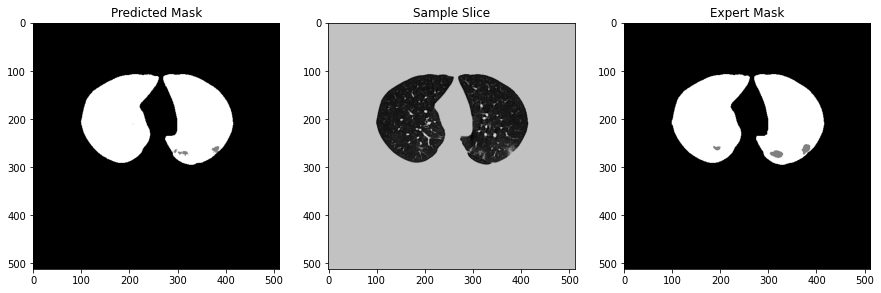

In [31]:
sample_index = np.random.randint(test_maskx.shape[0])
draw(sample_index,say = True)

### 4x Reconstruction

Making and Saving the 4x Reconstructions of the Test Cases

In [ ]:
# Making the Reconstructed CT scans from limited angles(4x)

theta = np.arange(0,181,4)
recon_4x = []
for i in range(test_maskx.shape[0]):

    image = test_scanx[i,:,:].astype(np.float64)
    sinogram = radon(image, theta=theta,circle = False)
    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512).astype(np.uint8)
    recon_4x.append(reconstruction_fbp)
   
recon_4x = np.array(recon_4x)

Finding the Dice Score, Accuracy, Sensitivity, Specificity of the predicted mask for INFECTED Regions

In [ ]:
get_metrics(recon_4x , test_maskx , class_ = 1)

1/1 [==============================] - 0s 26ms/step
Dice Score=0.04943911906186273 
SPEC=0.33631495666307554 
SENS=0.28779335052229954 
ACCURACY=0.32975590944613475 FOR INFECTED REGIONS


Finding the Dice Score, Accuracy, Sensitivity, Specificity of the predicted mask for NORMAL Regions

In [ ]:
get_metrics(recon_4x,test_maskx,class_ = 2)

1/1 [==============================] - 0s 17ms/step
Dice Score=0.5393635604556081 
SPEC=0.30336897445110433 
SENS=0.9399940854932777 
ACCURACY=0.5689997002864711 FOR NORMAL REGIONS


### 8x Reconstruction

Making and Saving the 8x Reconstructions of the Test Cases





In [ ]:
# Making the Reconstructed CT scans from limited angles(8x)

theta = np.arange(0,181,8)
recon_8x = []
for i in range(test_maskx.shape[0]):

    image = test_scanx[i,:,:].astype(np.float64)
    sinogram = radon(image, theta=theta,circle = False)
    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='hann',circle = False, output_size=512).astype(np.uint8)
    recon_8x.append(reconstruction_fbp)
   
recon_8x = np.array(recon_8x)

Finding the Dice Score, Accuracy, Sensitivity, Specificity of the predicted mask for INFECTED Regions

In [ ]:
get_metrics(recon_8x,test_maskx,class_ = 1)

1/1 [==============================] - 0s 19ms/step
Dice Score=0.04122725157985983 
SPEC=0.3243735045513591 
SENS=0.2663074297462067 
ACCURACY=0.321124553462605 FOR INFECTED REGIONS


Finding the Dice Score, Accuracy, Sensitivity, Specificity of the predicted mask for NORMAL Regions

In [ ]:
get_metrics(recon_8x,test_maskx,class_ = 2)

1/1 [==============================] - 0s 17ms/step
Dice Score=0.40983731539046375 
SPEC=0.16435166413060376 
SENS=0.9288793520067037 
ACCURACY=0.3954912548099642 FOR NORMAL REGIONS


###  Displaying a Sample Slice with Expert mask and Predicted Masks

In [ ]:
def draw_recon(sample_idx):

  recon4x = recon_4x[sample_idx,:,:]
  recon8x = recon_8x[sample_idx,:,:]

  x = unet.predict(recon_4x[sample_idx:sample_idx+1])
  x = x[0,:,:,:]
  pred4x = np.argmax(x,axis=-1)  

  x = unet.predict(recon_8x[sample_idx:sample_idx+1])
  x = x[0,:,:,:]
  pred8x = np.argmax(x,axis=-1) 

  figure_size = 10
  fig,ax = plt.subplots(2,2,figsize=(figure_size,figure_size))

  ax[0,0].set_title('4x reconstruction of the Sample Slice')
  ax[0,0].imshow(recon4x ,cmap='gray')

  ax[1,0].set_title('Predicted Mask on 4x reconstruction')
  ax[1,0].imshow(pred4x ,cmap='gray')

  ax[0,1].set_title('8x reconstruction of the Sample Slice')
  ax[0,1].imshow(recon8x ,cmap='gray')

  ax[1,1].set_title('Predicted Mask on 8x reconstruction')
  ax[1,1].imshow(pred8x ,cmap='gray')
  plt.show() 


1/1 [==============================] - 0s 18ms/step
Dice Score=0.6623644468099261 
SPEC=0.9841674220874621 
SENS=0.8295284119313447 
ACCURACY=0.9806245203852952 FOR INFECTED REGIONS 

Dice Score=0.8706822583413008 
SPEC=0.9952380952380953 
SENS=0.8112750696696971 
ACCURACY=0.9798763204376472 FOR Normal REGIONS 



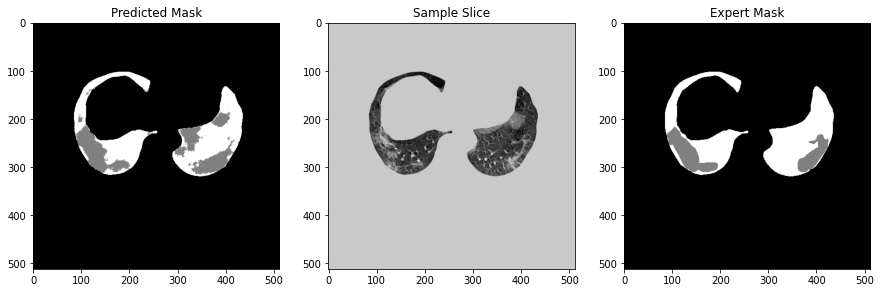

1/1 [==============================] - 0s 17ms/step


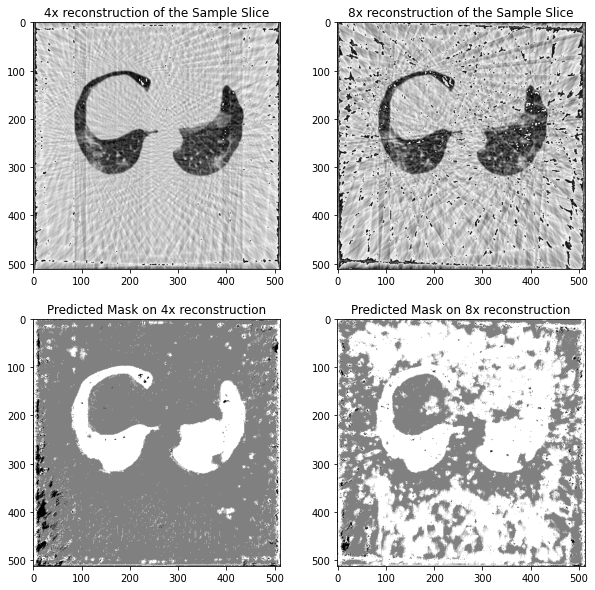

In [ ]:
sample_idx = np.random.randint(test_scanx.shape[0])
draw(sample_idx,say = True)
draw_recon(sample_idx)

In [ ]:
del recon_4x,recon_8x

### Perturbation of Weights

Function to Perturb Model Weights

In [32]:
Original_Weights = weights = np.array(unet.get_weights(), dtype=object) 
etas = [-0.01 , -0.001, 0.001 , 0.01]
def perturb(eta , draw_it = True):
  unet.set_weights(weights*(1+eta)) 
  print(f'Evaluation of the Model at {eta}% perturbation')
  unet.evaluate(test_scanx,test_maskx)
  if draw_it==True:
    sample_index = 40
    draw(sample_index,say = True)
  get_metrics(test_scanx , test_maskx , class_ = 1)
  get_metrics(test_scanx , test_maskx , class_ = 2)
  unet.set_weights(Original_Weights)

Evaluation of the Model at -0.01% perturbation
1/1 [==============================] - 0s 17ms/step
Dice Score=0.8803503882142145 
SPEC=0.997034223196111 
SENS=0.9095022624434389 
ACCURACY=0.9954085861730451 FOR INFECTED REGIONS 

Dice Score=0.9913511045730083 
SPEC=0.9965746315133901 
SENS=0.9906601274886261 
ACCURACY=0.9947929987975034 FOR Normal REGIONS 



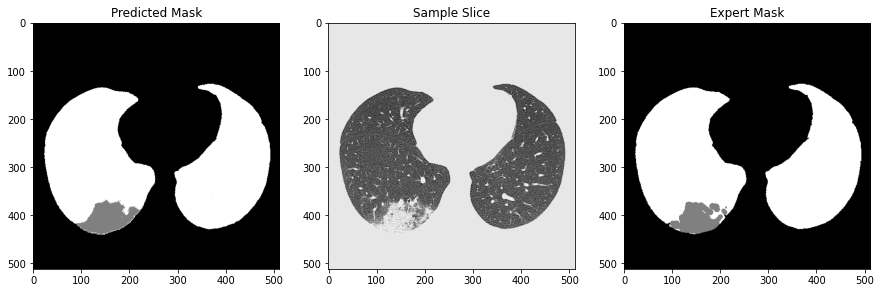

1/1 [==============================] - 0s 17ms/step
Dice Score=0.7021846062826201 
SPEC=0.9965015916885143 
SENS=0.7043640209363882 
ACCURACY=0.992716563496616 FOR INFECTED REGIONS
1/1 [==============================] - 0s 17ms/step
Dice Score=0.9585920987567178 
SPEC=0.9968780580784173 
SENS=0.9535870659357466 
ACCURACY=0.9947239197721202 FOR NORMAL REGIONS


In [ ]:
perturb(etas[0],draw_it = True)

Evaluation of the Model at -0.001% perturbation
1/1 [==============================] - 0s 18ms/step
Dice Score=0.8768902872221659 
SPEC=0.9973876616652002 
SENS=0.888523241464418 
ACCURACY=0.9953652758673391 FOR INFECTED REGIONS 

Dice Score=0.990976967856239 
SPEC=0.9954978582043885 
SENS=0.9923709589527177 
ACCURACY=0.9945558597045809 FOR Normal REGIONS 



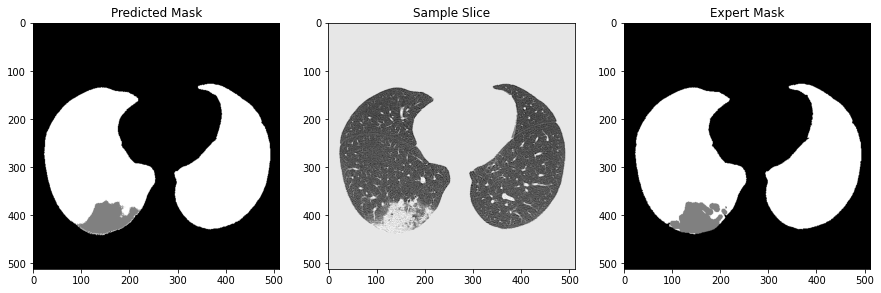

1/1 [==============================] - 0s 18ms/step
Dice Score=0.696435931503459 
SPEC=0.9970537076561633 
SENS=0.6785637847182405 
ACCURACY=0.9927133651384906 FOR INFECTED REGIONS
1/1 [==============================] - 0s 18ms/step
Dice Score=0.9602763643906409 
SPEC=0.9964074481641195 
SENS=0.9593576182051393 
ACCURACY=0.9947570065652607 FOR NORMAL REGIONS


In [ ]:
perturb(etas[1])

Evaluation of the Model at 0.001% perturbation
1/1 [==============================] - 0s 18ms/step
Dice Score=0.8747579741159686 
SPEC=0.997434280196848 
SENS=0.8827642945290004 
ACCURACY=0.9953039624011311 FOR INFECTED REGIONS 

Dice Score=0.9909057563147444 
SPEC=0.9952406972296596 
SENS=0.9928145078508155 
ACCURACY=0.9945097530152451 FOR Normal REGIONS 



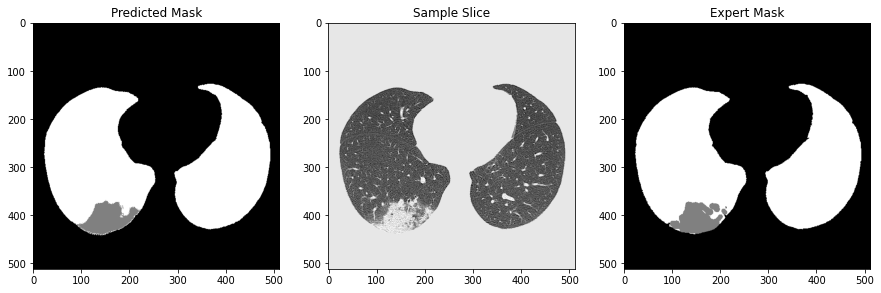

1/1 [==============================] - 0s 18ms/step
Dice Score=0.6969671266357506 
SPEC=0.9971600661352109 
SENS=0.675167266403268 
ACCURACY=0.9926907886052019 FOR INFECTED REGIONS
1/1 [==============================] - 0s 20ms/step
Dice Score=0.9605267904718551 
SPEC=0.9962948187030358 
SENS=0.9605217662032628 
ACCURACY=0.9947445677998512 FOR NORMAL REGIONS


In [ ]:
perturb(etas[2])

Evaluation of the Model at 0.01% perturbation
1/1 [==============================] - 0s 17ms/step
Dice Score=0.8625858838226109 
SPEC=0.9976593291894502 
SENS=0.8521184697655286 
ACCURACY=0.9949546298915245 FOR INFECTED REGIONS 

Dice Score=0.9901642240209964 
SPEC=0.9938673779487964 
SENS=0.9944619751866074 
ACCURACY=0.9940465507036068 FOR Normal REGIONS 



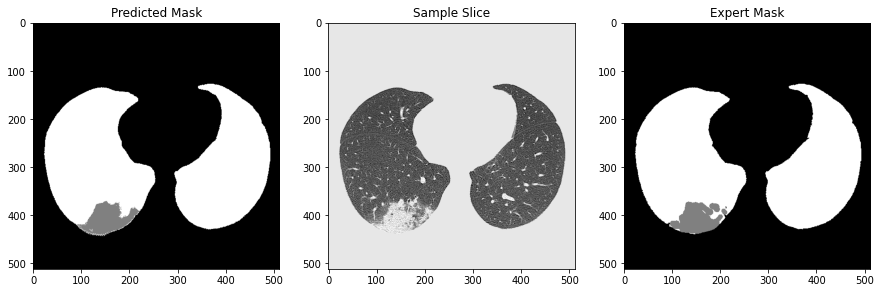

1/1 [==============================] - 0s 17ms/step
Dice Score=0.6918310062252856 
SPEC=0.9975759704526025 
SENS=0.654625448373966 
ACCURACY=0.9925119780852539 FOR INFECTED REGIONS
1/1 [==============================] - 0s 20ms/step
Dice Score=0.9612908134751423 
SPEC=0.9957477998531218 
SENS=0.9654369504805698 
ACCURACY=0.9946087097054092 FOR NORMAL REGIONS


In [ ]:
perturb(etas[3])

### Uncertainty

In [20]:
def one_slice_uncertainty(scan_idx):
  X = unet.predict(test_scanx[scan_idx:scan_idx+1])
  X = X[0,:,:,:]
  Uc = np.abs(-X*np.log(X))
  Umap=Uc
  Umap[X<10**-7] = 0
  Umap = np.mean(Umap , axis = -1)
  U_score = np.sum(X)
  return Umap,U_score,X

In [21]:
def Uncertainty(eta=0,draw = True,sample_idx = 1):
  if eta>0:
    W = np.array(unet.get_weights(), dtype=object) 
    unet.set_weights(W*(1+eta)) 
  UC =  one_slice_uncertainty(sample_idx)
  Uc_score = UC[1]
  Uc_map = np.array(UC[0])
  pred = UC[2]
  mini = min(Uc_map.flatten())
  maxi = max(Uc_map.flatten())
  Uc_map = (Uc_map - mini)/(maxi - mini)
  if draw==True:
    pred = np.argmax(pred,axis=-1)  

    fig,ax = plt.subplots(2,2,figsize=(10,10))
    fig.suptitle(f'The Plots for eta = {eta}')
    ax[0,0].set_title('Original Slice')
    ax[0,0].imshow(test_scanx[sample_idx] ,cmap='gray')

    ax[1,0].set_title('Expert Mask')
    ax[1,0].imshow(test_maskx[sample_idx] ,cmap='gray')

    ax[0,1].set_title('Uncertainty Map')
    ax[0,1].imshow(Uc_map ,cmap='gray')

    ax[1,1].set_title('Predicted Mask')
    ax[1,1].imshow(pred ,cmap='gray')
    plt.show() 
  if eta>0:
    unet.set_weights(W)

1/1 [==============================] - 9s 9s/step


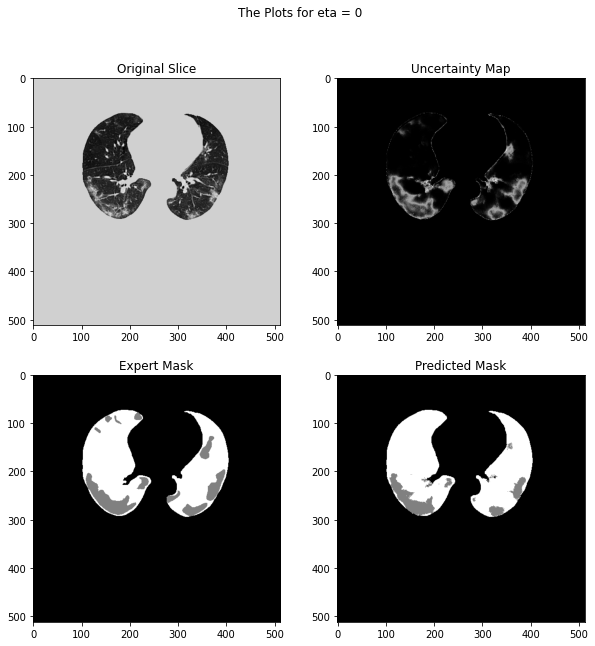

In [22]:
Uncertainty()

1/1 [==============================] - 0s 18ms/step


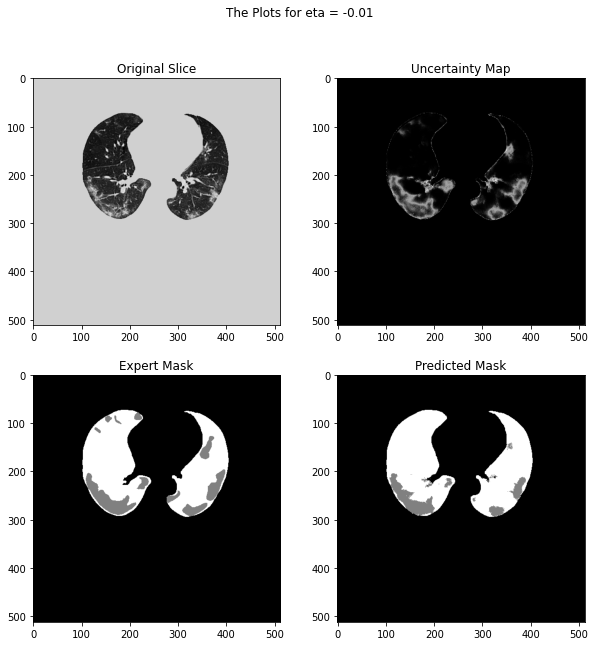

In [23]:
Uncertainty(eta = -0.01)

1/1 [==============================] - 0s 20ms/step


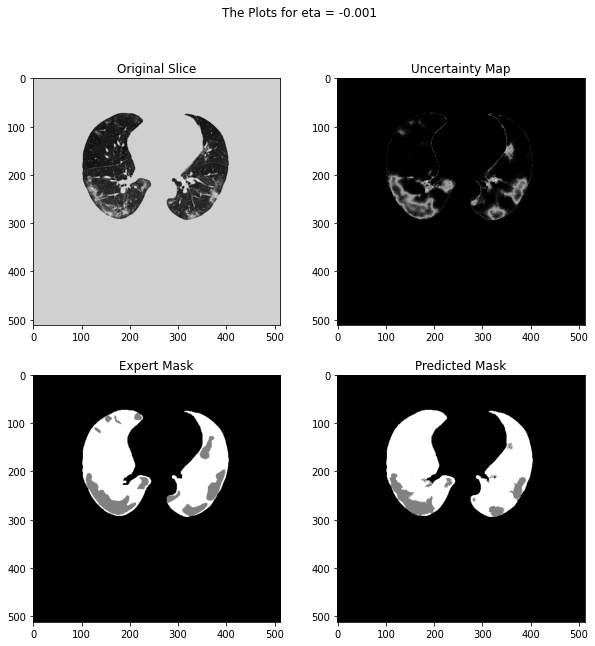

In [24]:
Uncertainty(eta = -0.001)

1/1 [==============================] - 0s 18ms/step


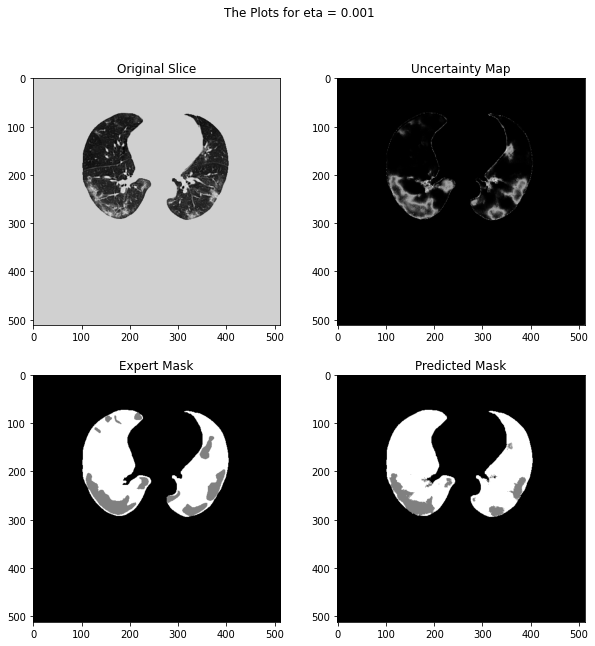

In [25]:
Uncertainty(eta = 0.001)

1/1 [==============================] - 0s 50ms/step


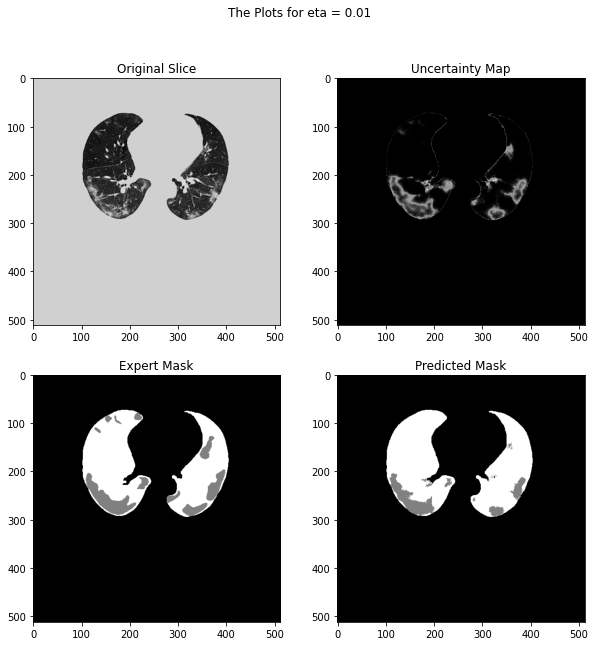

In [26]:
Uncertainty(eta = 0.01)